# 07 Analysis of spatial transcriptomics

- Åsa Björklund
- Paulo Czarnewski

- Spatial Omics Data Analysis 2022

In this tutorial, we will perform analysis of the spatial transcriptomics data (10X Visium technology), which will be used in combination with the single cell and the _in situ_ sequencing data to produce even more refined results. Please note that this tutorial is a brief overview of the methods and functions commonly used for single cell, too. If you are unfaminiar with such analysis, we recomend you to follow first the Single Cell Data Analysis course: https://nbisweden.github.io/workshop-scRNAseq/exercises

***

## Loading libraries

In [1]:
import warnings
import scanpy as sc
import squidpy as sq
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import scanorama
import os

sc.settings.set_figure_params(dpi=80)
# sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

***

## Loading the dataset

In [2]:
adata = sc.read_h5ad('../results/spatial_transcriptomics/visium.h5ad')
adata

/Users/hannah.spitzer/opt/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 716 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

As you can see, we now have the slot spatial in obsm, which contains the spatial information from the Visium platform. We can plot the tissues stored in the object with `Squidpy` as shown below:

In [5]:
adata.uns['spatial'].keys()

dict_keys(['154441', '154442'])

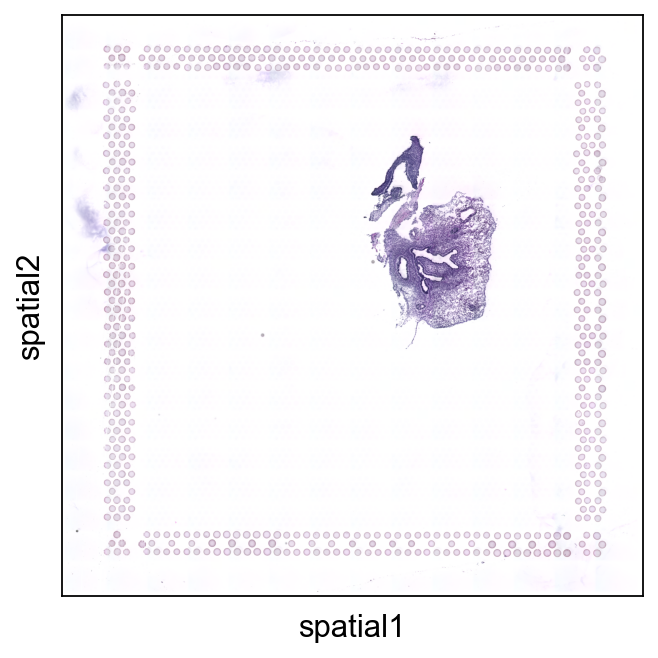

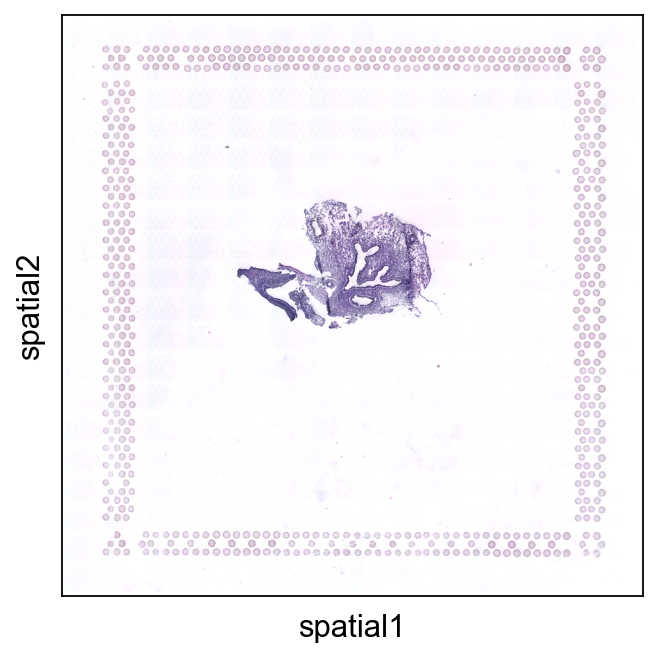

In [6]:
for library_id in adata.uns['spatial'].keys():
    sq.pl.spatial_scatter(adata, library_id=library_id)

As you can see, we have 2 consecutive slides from the same tissue, but rotated about 90 degrees. We will explore later how to combine them, but for now, lets continue performin the data analysis.

***

##  Quality control

Similar to scRNAseq we use statistics on number of counts, number of features and percent mitochondria for quality control.

In [8]:
# add info on mitochondrial and hemoglobin genes to the objects.
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
adata.var['hb'] = adata.var_names.str.contains(("^HB[AB]"))
adata.var['ribo'] = adata.var_names.str.contains(("^RP[LS]"))

sc.pp.calculate_qc_metrics(
    adata, qc_vars=['mt','hb','ribo'], 
    percent_top=None, log1p=False, inplace=True)

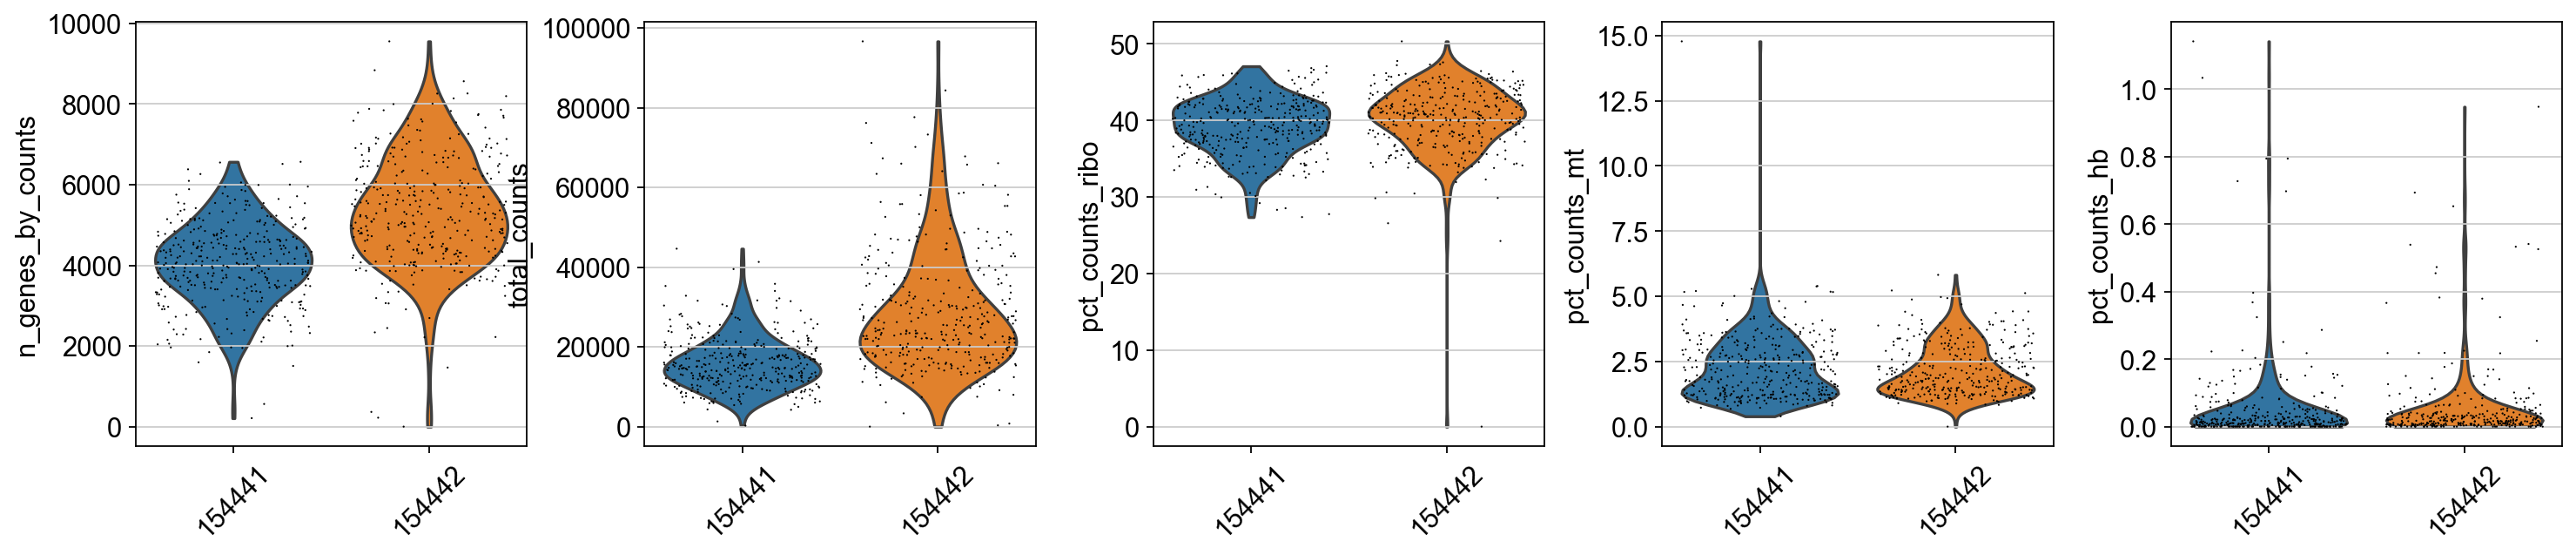

In [9]:
sc.pl.violin(adata, 
             keys = ['n_genes_by_counts', 'total_counts','pct_counts_ribo',
                     'pct_counts_mt', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sample_id', rotation= 45)

We can also plot the same data onto the tissue section, again using `squidpy.pl.spatial_scatter`, this time specifying a color for the spots. To plot the correct spots on the right image, we need to set `library_key` to the name of the `adata.obs` columns that does the mapping between spots and `library_ids` - this is `sample_id` in our case. 

In [18]:
adata.obs

in_tissue  array_row  array_col sample_id  \
AAACGAGACGGTTGAT-1          1         35         79    154442   
AAAGGGATGTAGCAAG-1          1         24         62    154442   
AAATTAACGGGTAGCT-1          1         34         58    154442   
AACCGAGCTTGGTCAT-1          1         24         70    154442   
AACGCGGTCTCCAGCC-1          1         23         65    154442   
...                       ...        ...        ...       ...   
TTGGCCTAGAATTTCG-1          1         16         82    154441   
TTGGGACACTGCCCGC-1          1         28         70    154441   
TTGGGCGGCGGTTGCC-1          1         30         76    154441   
TTGTAAGGCCAGTTGG-1          1         27         81    154441   
TTGTTGTGTGTCAAGA-1          1         31         77    154441   

                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACGAGACGGTTGAT-1               6660       30206.0            348.0   
AAAGGGATGTAGCAAG-1               5757       35336.0           1318.0   
AAATTAACGGGTAGCT-1               5071       23512.0            403.0   
AACCGAGCTTGGTCAT-1               3991       17338.0            620.0   
AACGCGGTCTCCAGCC-1               4675       23137.0            766.0   
...                               ...           ...              ...   
TTGGCCTAGAATTTCG-1               4703       21456.0            448.0   
TTGGGACACTGCCCGC-1               2670        9501.0            511.0   
TTGGGCGGCGGTTGCC-1               2645        8416.0             89.0   
TTGTAAGGCCAGTTGG-1               4644       19493.0            552.0   
TTGTTGTGTGTCAAGA-1               4661       17576.0            237.0   

                    pct_counts_mt  total_counts_hb  pct_counts_hb  \
AAACGAGACGGTTGAT-1       1.152089              0.0       0.000000   
AAAGGGATGTAGCAAG-1       3.729907             16.0       0.045280   
AAATTAACGGGTAGCT-1       1.714018              1.0       0.004253   
AACCGAGCTTGGTCAT-1       3.575960              2.0       0.011535   
AACGCGGTCTCCAGCC-1       3.310714              6.0       0.025932   
...                           ...              ...            ...   
TTGGCCTAGAATTTCG-1       2.087994              1.0       0.004661   
TTGGGACACTGCCCGC-1       5.378381              4.0       0.042101   
TTGGGCGGCGGTTGCC-1       1.057510              1.0       0.011882   
TTGTAAGGCCAGTTGG-1       2.831786              1.0       0.005130   
TTGTTGTGTGTCAAGA-1       1.348430              3.0       0.017069   

                    total_counts_ribo  pct_counts_ribo  
AAACGAGACGGTTGAT-1             9198.0        30.450905  
AAAGGGATGTAGCAAG-1            15766.0        44.617386  
AAATTAACGGGTAGCT-1             9446.0        40.175228  
AACCGAGCTTGGTCAT-1             7722.0        44.538010  
AACGCGGTCTCCAGCC-1            10306.0        44.543369  
...                               ...              ...  
TTGGCCTAGAATTTCG-1             8779.0        40.916294  
TTGGGACACTGCCCGC-1             4046.0        42.584991  
TTGGGCGGCGGTTGCC-1             3548.0        42.157795  
TTGTAAGGCCAGTTGG-1             7044.0        36.136047  
TTGTTGTGTGTCAAGA-1             6344.0        36.094673  

[716 rows x 12 columns]

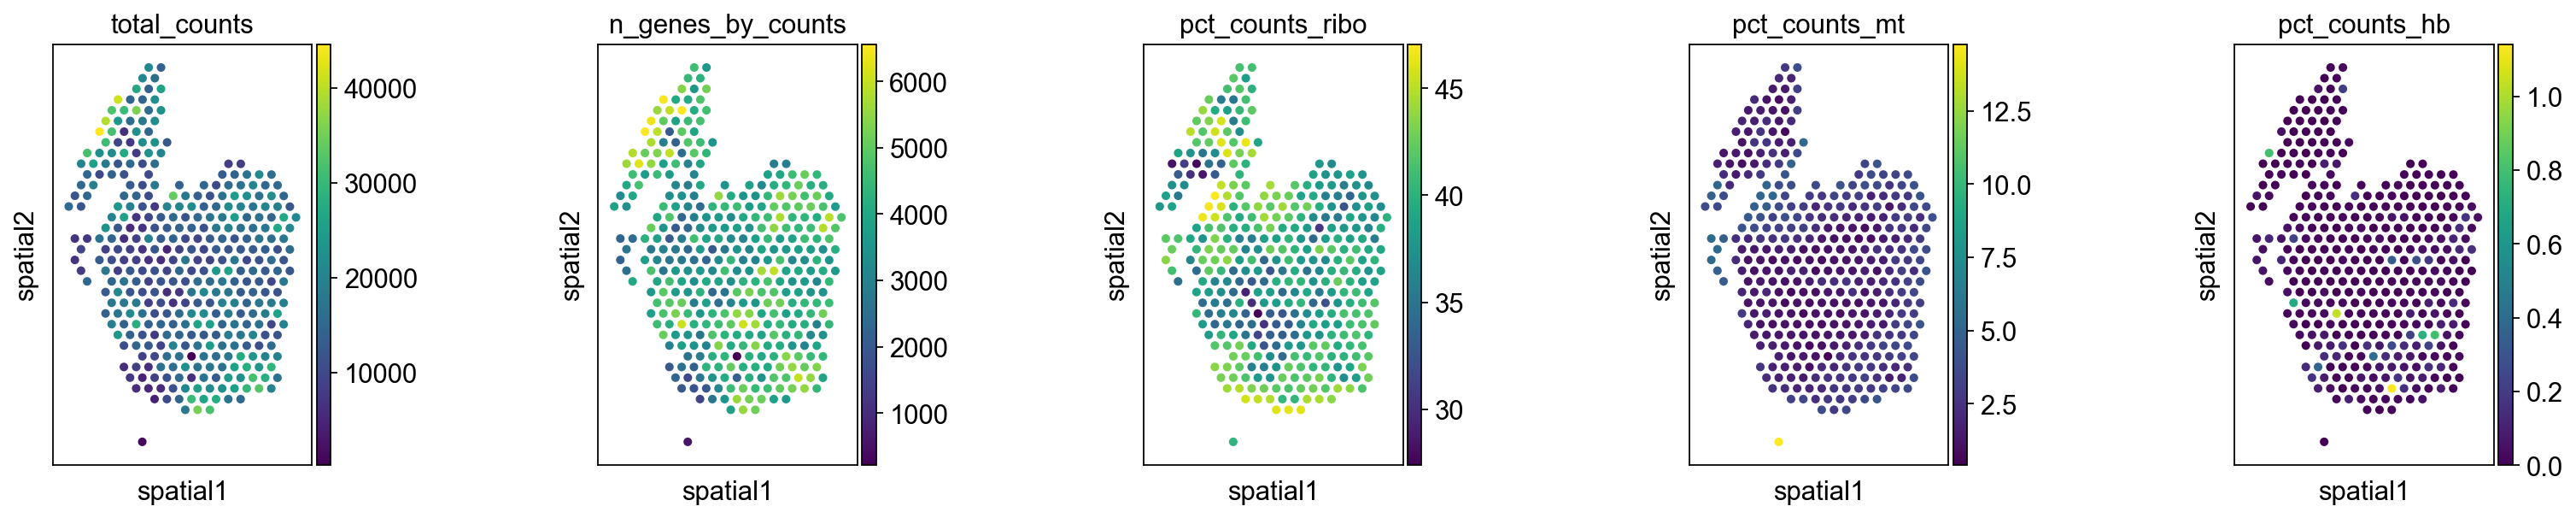

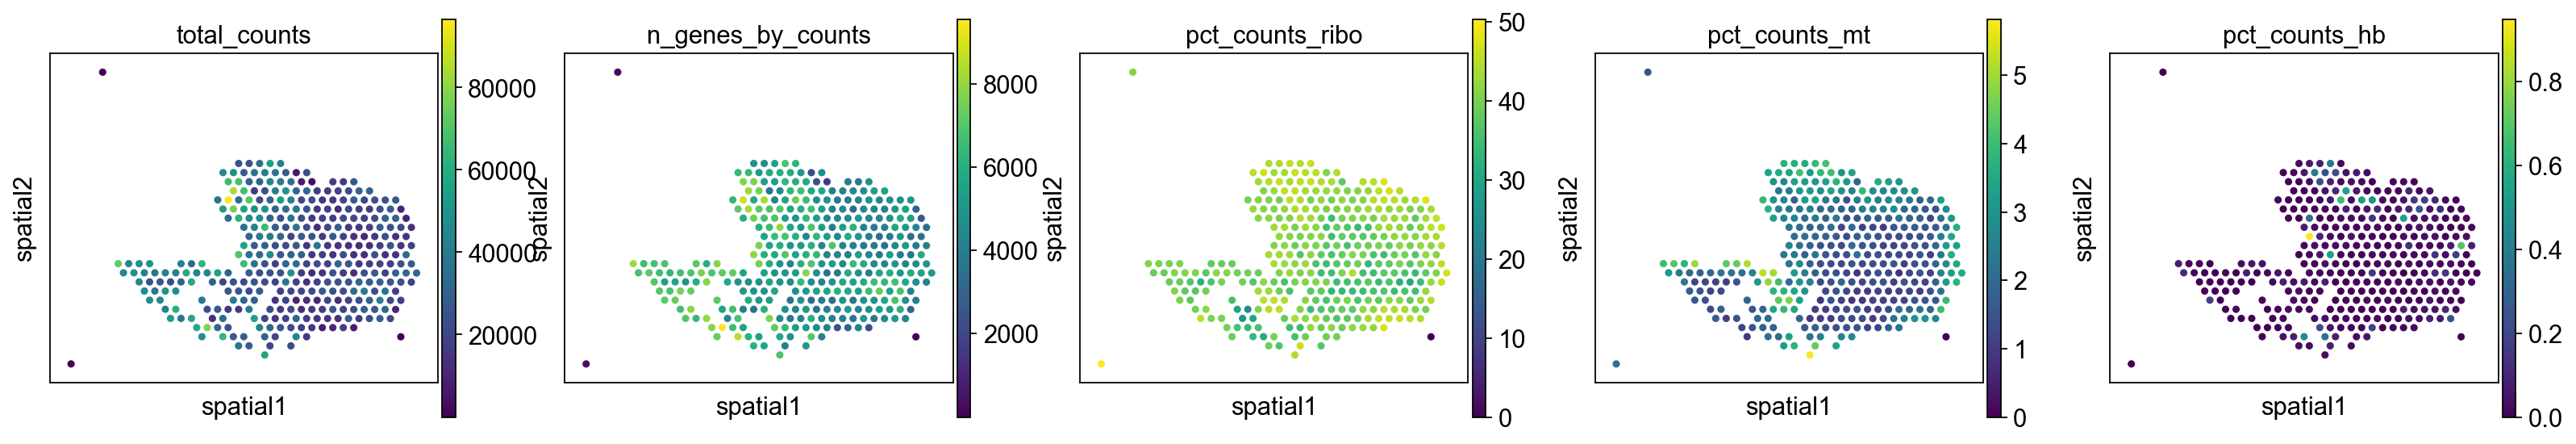

In [21]:
for library_id in adata.uns['spatial'].keys():
    sq.pl.spatial_scatter(adata, library_id=library_id, color = [
            'total_counts', 'n_genes_by_counts','pct_counts_ribo',
            'pct_counts_mt', 'pct_counts_hb'], ncols=5, library_key='sample_id',
        img=False)

As you can see, the spots with low number of counts/features and high mitochondrial content is mainly towards the edges of the tissue. You may also see regions within a tissue with low quality if you have tears or folds in your section. But remember, for some tissue types, the amount of genes expressed and proportion mitochondria may also be a biologicaly meaningfull, so bear in mind what tissue you are working on and what these features mean.

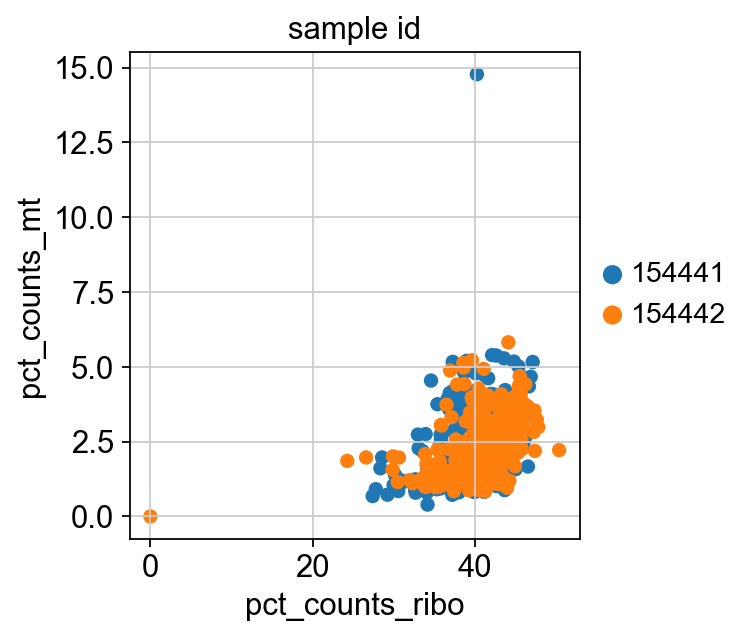

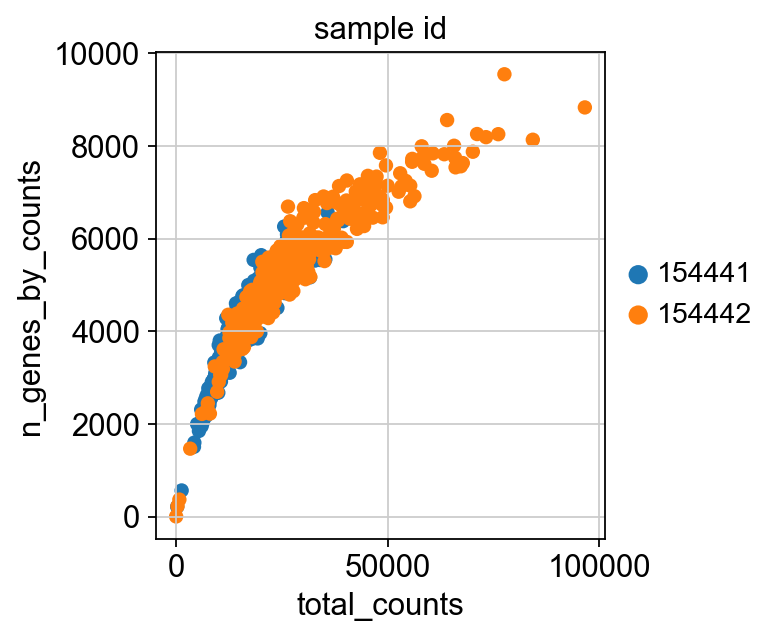

In [22]:
sc.pl.scatter(adata, x='pct_counts_ribo', y='pct_counts_mt', color="sample_id")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color="sample_id")

## Top expressed genes

normalizing counts per cell
    finished (0:00:00)


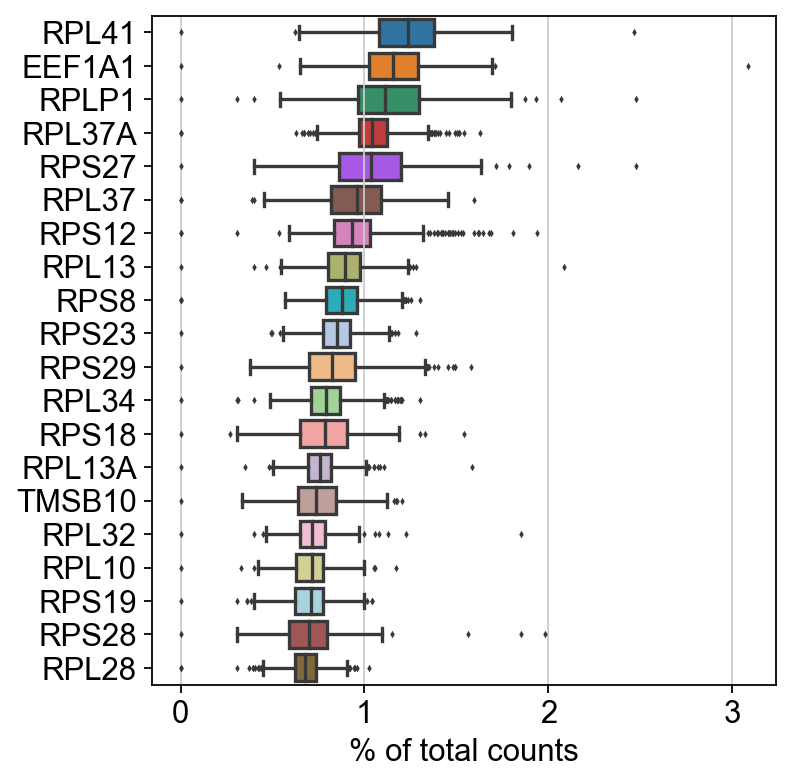

In [23]:
sc.pl.highest_expr_genes(adata, n_top=20)

***

##  Cell and Gene Filtering

Select all spots with less than 10% mitocondrial reads, more than 20% ribossomal reads and 1000 detected genes. You must judge for yourself based on your knowledge of the tissue what are appropriate filtering criteria for your dataset.

In [24]:
remove = adata.var_names.str.startswith('MT-')
keep = np.invert(remove)
print(sum(remove))

adata = adata[:,keep]

13


***

## Normalization

Before cell cycle and variable gene selection we have to normalize the data. In the scanpy object, the data slot will be overwritten with the normalized data. So first, save the raw data into the slot raw. Here, we perform the log(CP10K) normalization.

In [25]:
# save normalized counts in raw slot.
adata.raw = adata

# normalize to depth 10000 UMIs per cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)

normalizing by total count per cell


/Users/hannah.spitzer/opt/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/Users/hannah.spitzer/opt/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


***

## Calculate cell-cycle scores

We here perform cell cycle scoring. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

First read the file with cell cycle genes, from Regev lab and split into S and G2M phase genes. Cell cycle genes were retrieved from the scanpy_usage github site via web browser at [RegevLab Github repo](https://github.com/theislab/scanpy_usage/blob/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt).

In [26]:
# Load gene list from file
cell_cycle_genes = [x.strip() for x in open('../results/regev_lab_cell_cycle_genes.txt')]

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

# Filter out genes not detectd in our dataset 
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

We here perform cell cycle scoring. The function is actually a wrapper to sc.tl.score_gene_list, which is launched twice, to score separately S and G2M phases. Both sc.tl.score_gene_list and sc.tl.score_cell_cycle_genes are a port from Seurat and are supposed to work in a very similar way. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

In [27]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    430 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    301 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


We can now plot a violin plot for the cell cycle scores as well.

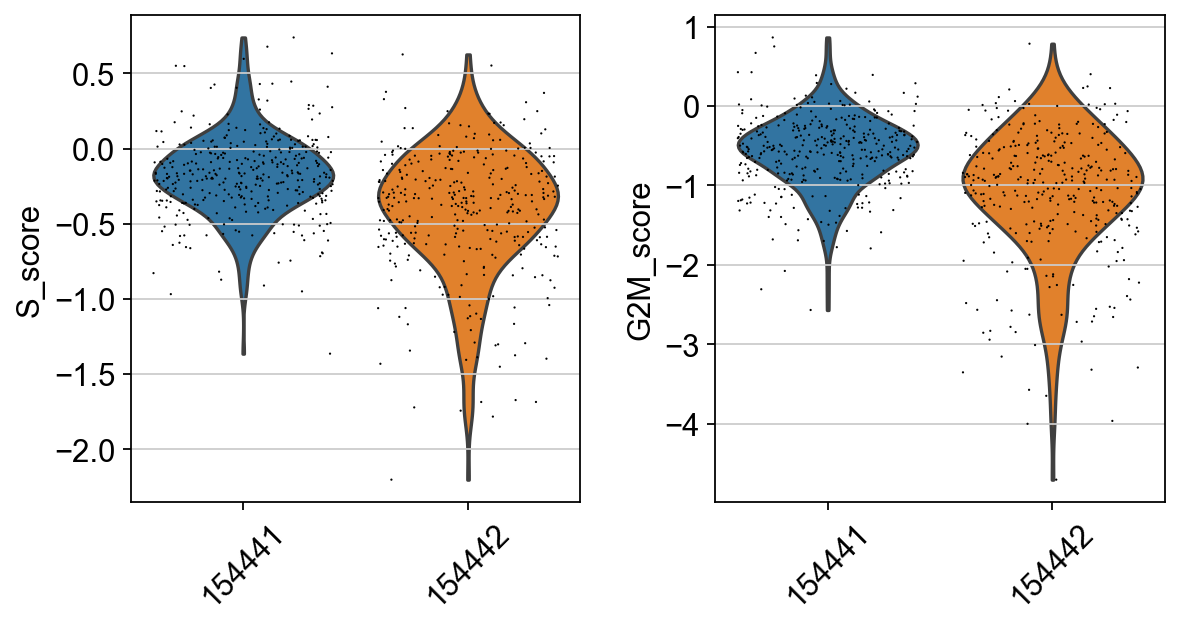

In [28]:
sc.pl.violin(adata, ['S_score', 'G2M_score'], jitter=0.4, groupby = 'sample_id', rotation=45)

In this case it looks like we only have a few cycling cells in the datasets.

***

## Variable feature selection

Next, we first need to define which features/genes are important in our dataset to distinguish cell types. For this purpose, we need to find genes that are highly variable across cells, which in turn will also provide a good separation of the cell clusters.

As we have two sections, we will select variable genes with batch_key="library_id" and then take the union of variable genes for further analysis. The idea is to avoid including batch specific genes in the analysis.

In [29]:
sc.pp.highly_variable_genes(
    adata=adata, flavor="seurat", 
    n_top_genes=2000, inplace=True, 
    batch_key="sample_id")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Now we can plot gene expression of individual genes.

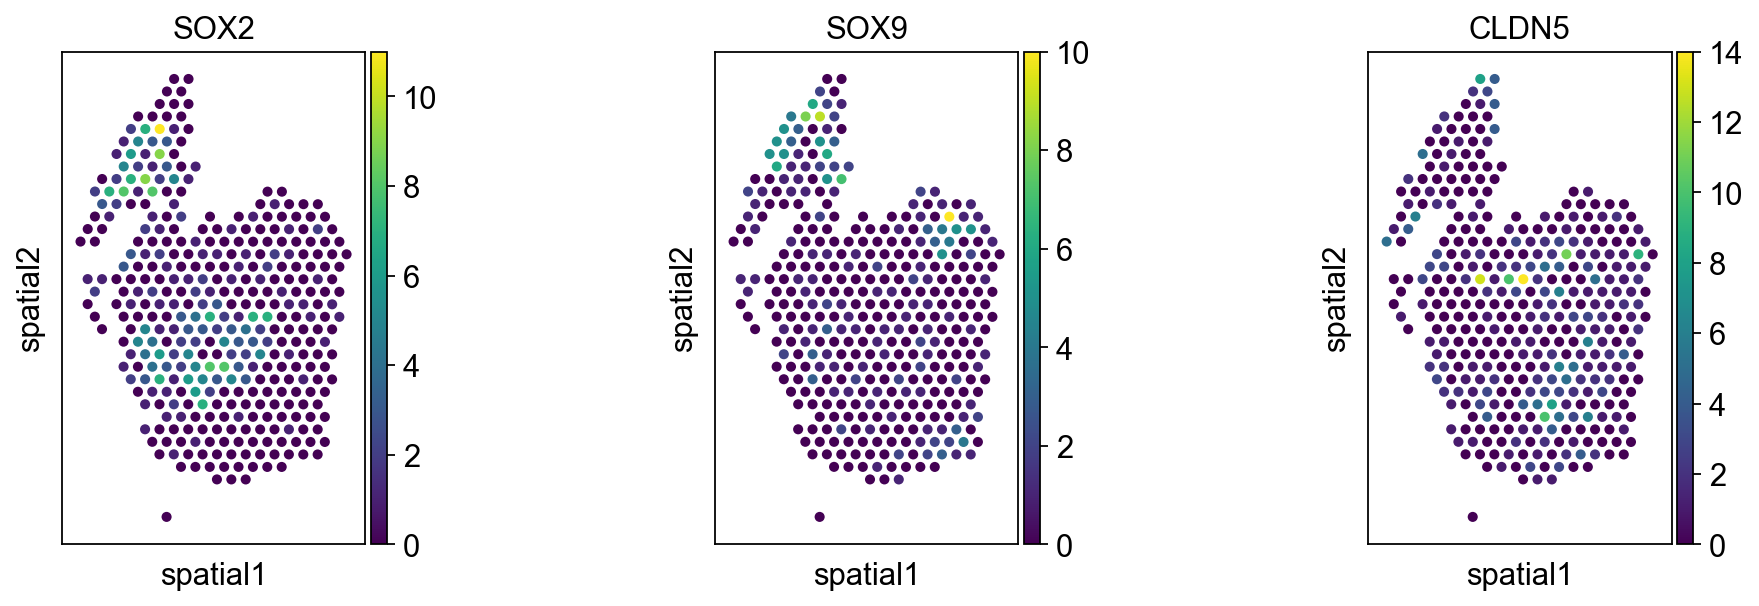

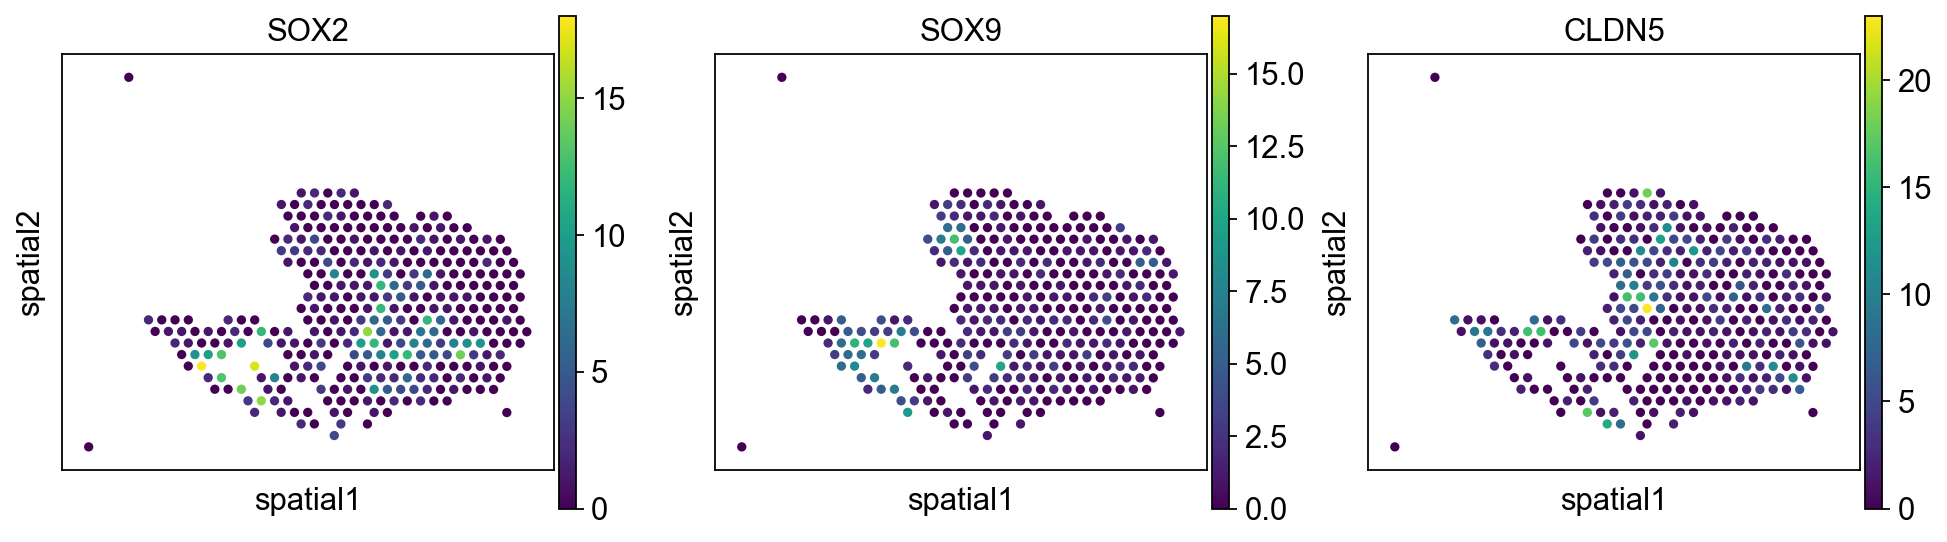

In [31]:
for library_id in adata.uns['spatial'].keys():
    sq.pl.spatial_scatter(adata, library_id=library_id, color = ['SOX2','SOX9','CLDN5'], 
        ncols=5, library_key='sample_id', img=False)

***

## Data integration

Quite often there are strong batch effects between different ST sections, so it may be a good idea to integrate the data across sections. We will do a similar integration as for the single cell dataset, using Scanorama.

In [32]:
adatas = {}
for batch in adata.obs.sample_id.unique():
    adatas[batch] = adata[adata.obs['sample_id'] == batch,]

adatas 

{'154442': View of AnnData object with n_obs × n_vars = 347 × 33525
     obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'S_score', 'G2M_score', 'phase'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'hb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'spatial', 'sample_id_colors', 'log1p', 'hvg'
     obsm: 'spatial',
 '154441': View of AnnData object with n_obs × n_vars = 369 × 33525
     obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'S_score', 'G2M_score', 'phase'
     var

In [33]:
#convert to list of AnnData objects
adatas = list(adatas.values())

# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 50)

# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]

# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# add to the AnnData object
adata.obsm["Scanorama"] = all_s

Found 33525 genes among all datasets
[[0.         0.97694524]
 [0.         0.        ]]
Processing datasets (0, 1)
(716, 50)


***

## Dimensionality reduction and clustering

We can then now run dimensionality reduction and clustering using the same workflow as we use for scRNA-seq analysis.

In [34]:
sc.pp.neighbors(adata,use_rep="Scanorama")
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


In [35]:
sc.tl.leiden(adata, resolution = 1.2, key_added = 'clusters')

running Leiden clustering
    finished: found 12 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


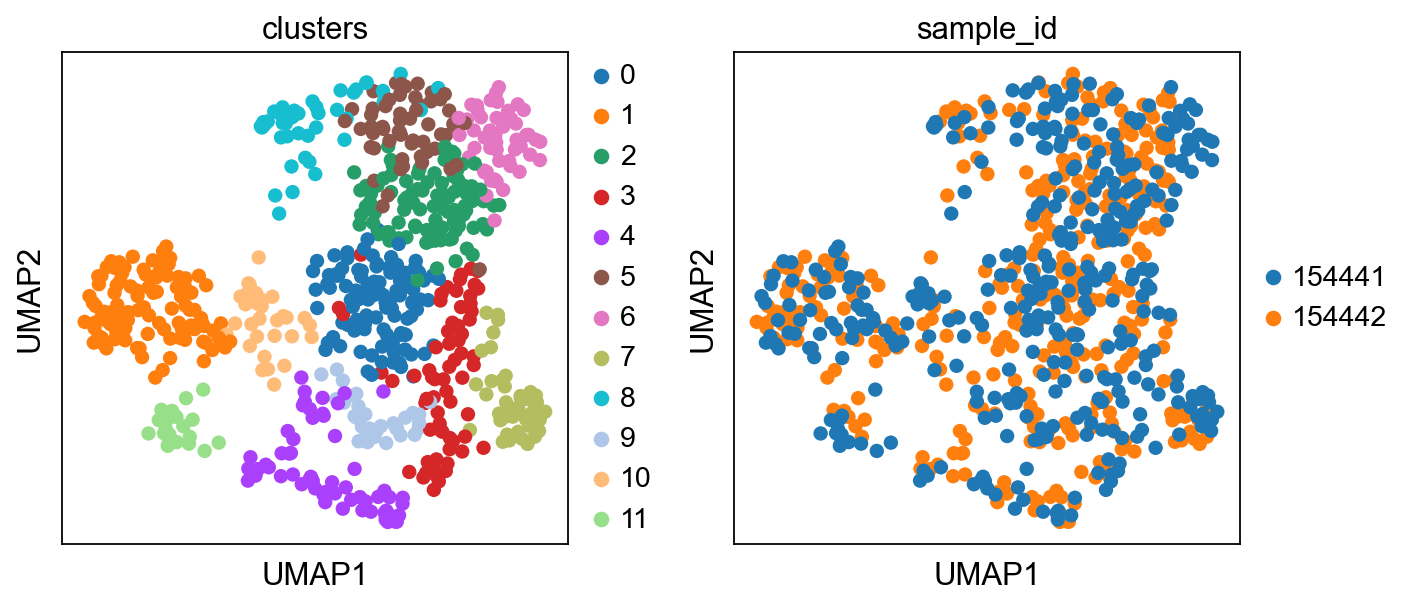

In [36]:
sc.pl.umap(
    adata, color=["clusters", "sample_id"], palette=sc.pl.palettes.default_20
)

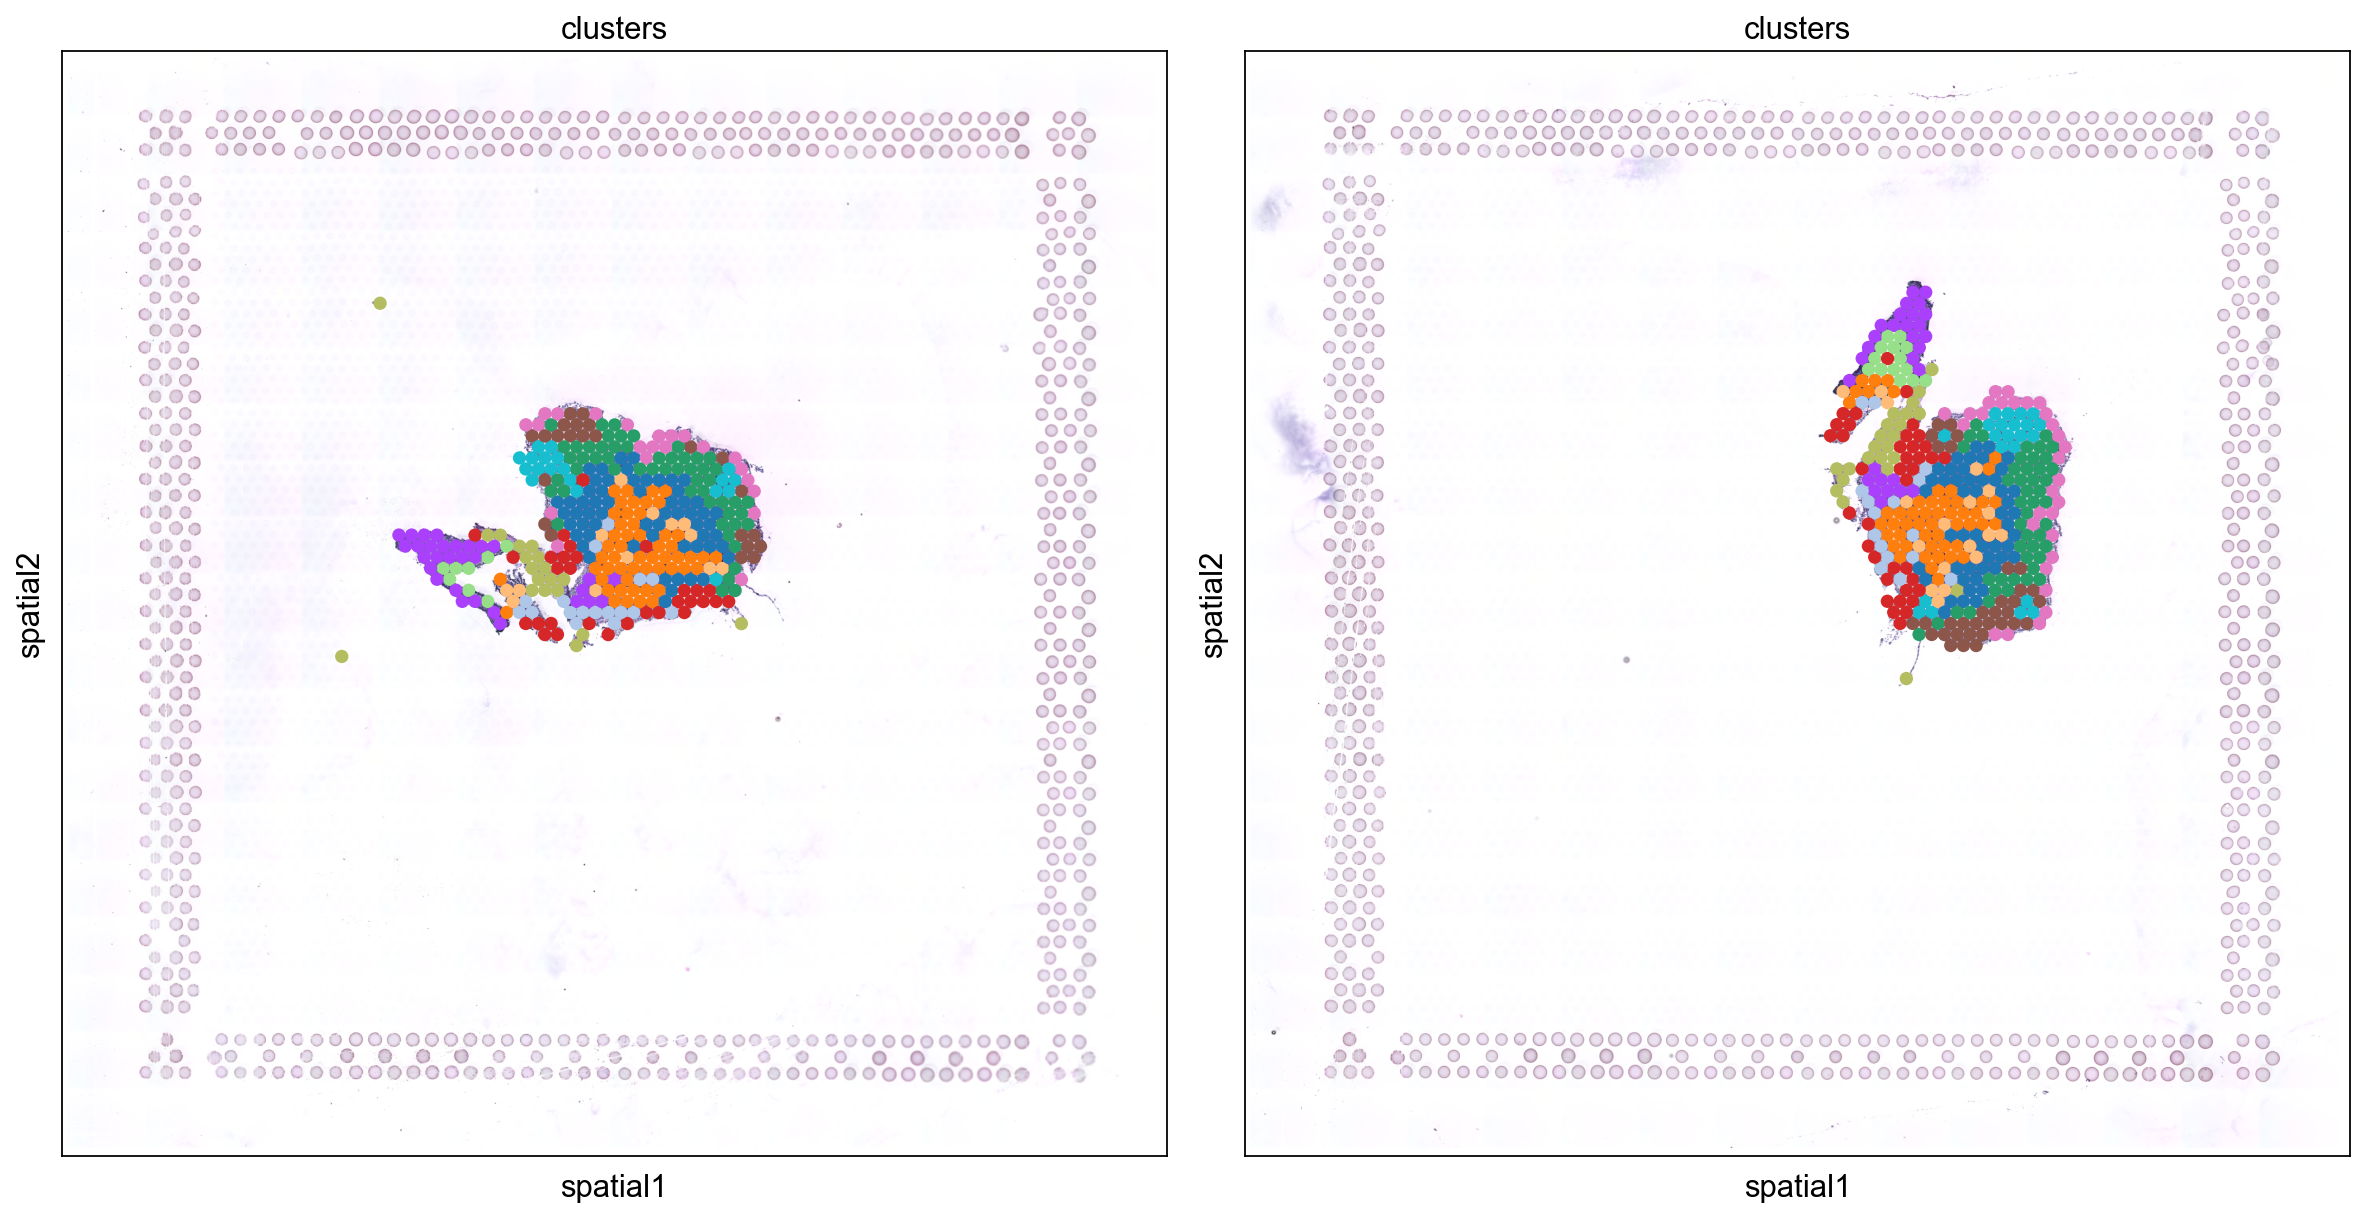

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

for i, library in enumerate(
    adata.obs.sample_id.unique()
):
    ad = adata[adata.obs.sample_id == library, :].copy()
    sq.pl.spatial_scatter(adata, library_id=library, color = "clusters", 
        size=1.5, library_key='sample_id',  
        legend_loc=None,
        ax=axs[i],)

plt.tight_layout()

Lets save the integrated data for further analysis.

In [45]:
os.makedirs('../results/spatial_transcriptomics', exist_ok=True)
adata.write_h5ad('../results/spatial_transcriptomics/spatial_transcriptomics_qc_int_dr_cl.h5ad')

***

## Differential gene expression

Once we have done clustering, let's compute a ranking for the highly differential genes in each cluster.
Differential expression is performed with the function rank_genes_group. The default method to compute differential expression is the t-test_overestim_var. Other implemented methods are: logreg, t-test and wilcoxon.

By default, the `.raw` attribute of AnnData is used in case it has been initialized, it can be changed by setting `use_raw=False`. The `leiden_0.6` clustering resolution seems to give a reasonable number of clusters, so we will use that clustering for all DE tests.

In [46]:
adata = sc.read_h5ad('../results/spatial_transcriptomics/spatial_transcriptomics_qc_int_dr_cl.h5ad')
adata

/Users/hannah.spitzer/opt/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 716 × 33525
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'S_score', 'G2M_score', 'phase', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'hb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'clusters_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'sample_id_colors', 'spatial', 'umap'
    obsm: 'Scanorama', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [47]:
print(adata.X.shape)
print(adata.raw.X.shape)
print(adata.raw.X[:10,:15])

(716, 33525)
(716, 33525)
  (0, 14)	1.0


As you can see, the X matrix only contains the variable genes, while the raw matrix contains all genes. Printing a few of the values in adata.raw.X shows that the raw matrix is not normalized. For DGE analysis we would like to run with all genes, but on normalized values, so we will have to revert back to the raw matrix and renormalize.

In [48]:
adata = adata.raw.to_adata()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [49]:
sc.tl.rank_genes_groups(adata, groupby='clusters', method='t-test')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:04)
Storing dendrogram info using `.uns['dendrogram_clusters']`


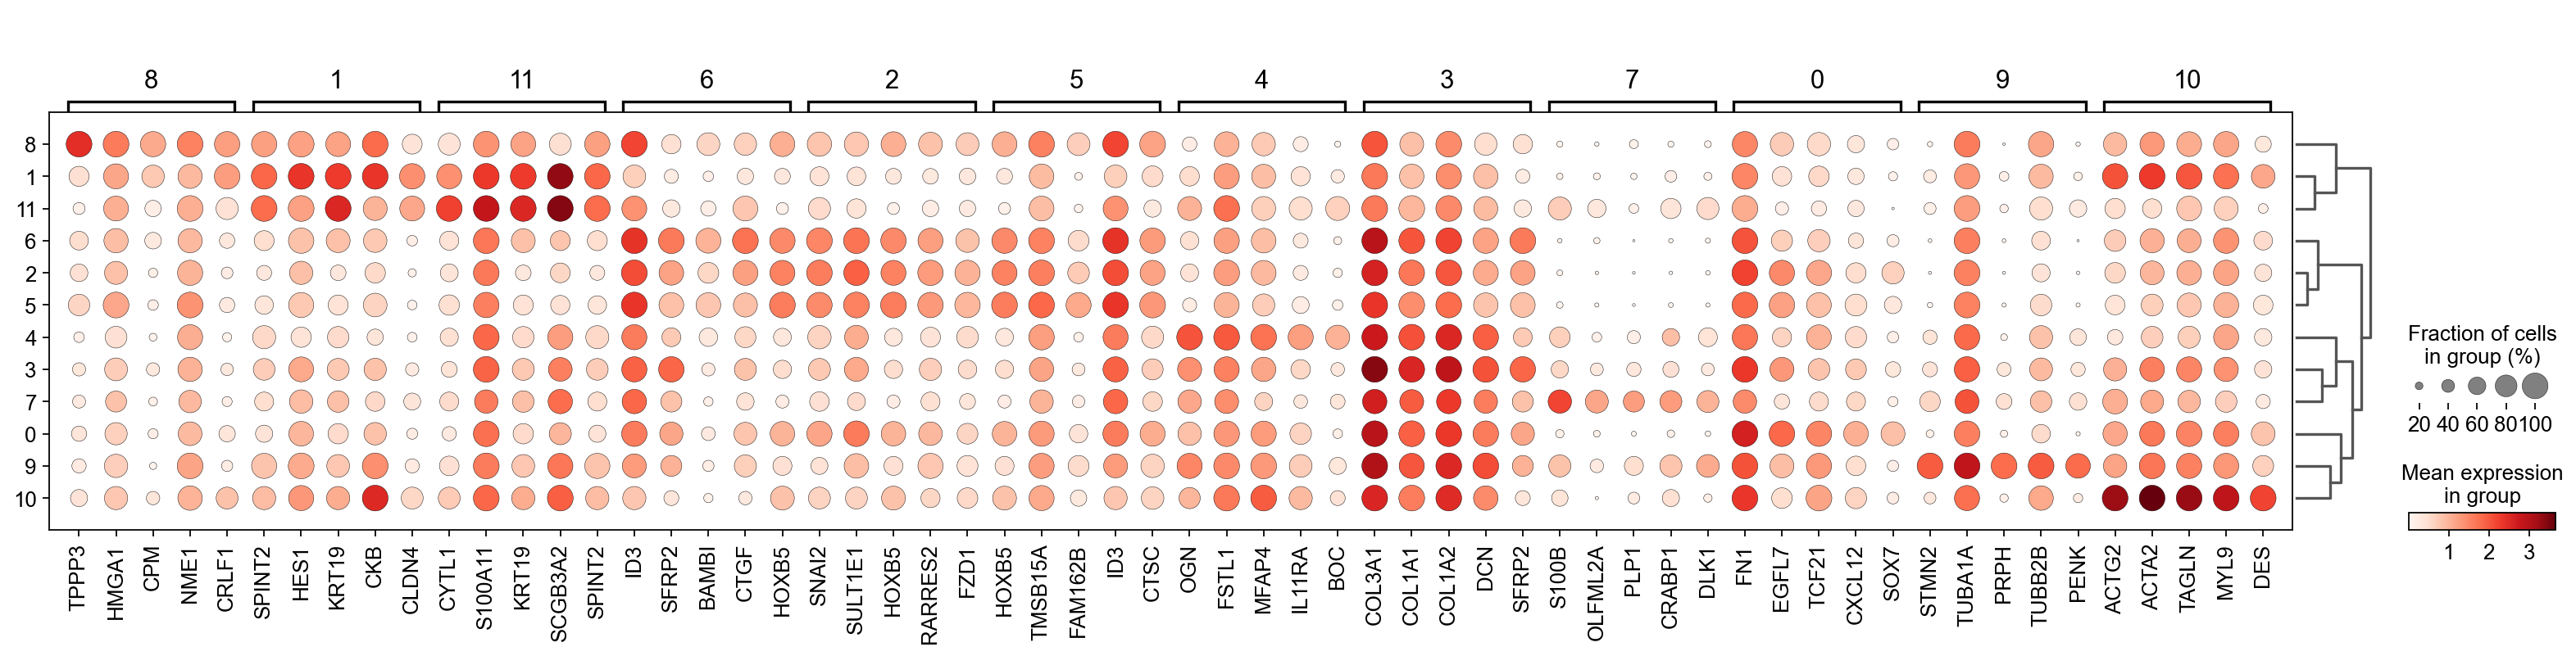

In [50]:
sc.pl.rank_genes_groups_dotplot(
    adata, n_genes=5, groupby="clusters",min_logfoldchange=1)